## Uczenie maszynowe – zastosowania
# 11. Wielowarstwowe sieci neuronowe w praktyce

## 11.1. Funkcje aktywacji

* Każda funkcja aktywacji ma swoje zalety i wady.
* Różne rodzaje funkcji aktywacji nadają się do różnych zastosowań.

In [1]:
%matplotlib inline

import math
import matplotlib.pyplot as plt
import numpy as np
import random

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, SimpleRNN, LSTM
from keras.optimizers import Adagrad, Adam, RMSprop, SGD

from IPython.display import YouTubeVideo

/home/pawel/.local/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def plot(fun):
    x = np.arange(-3.0, 3.0, 0.01)
    y = [fun(x_i) for x_i in x]
    fig = plt.figure(figsize=(14, 7))
    ax = fig.add_subplot(111)
    fig.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9)
    ax.set_xlim(-3.0, 3.0)
    ax.set_ylim(-1.5, 1.5)
    ax.grid()
    ax.plot(x, y)
    plt.show()

### Funkcja logistyczna

$$ g(x) = \frac{1}{1 + e^{-x}} $$

* Przyjmuje wartości z przedziału $(0, 1)$.

#### Funkcja logistyczna – wykres

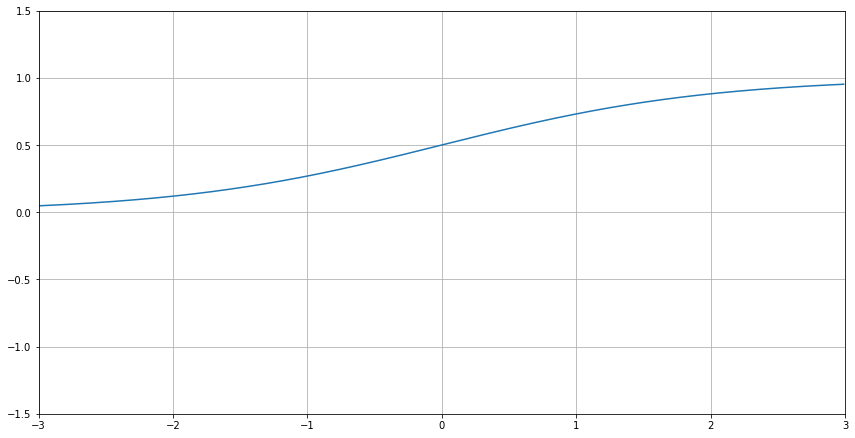

In [3]:
plot(lambda x: 1 / (1 + math.exp(-x)))

### Tangens hiperboliczny

$$ g(x) = \tanh x = \frac{e^{x} - e^{-x}}{e^{x} + e^{-x}} $$

* Przyjmuje wartości z przedziału $(-1, 1)$.
* Powstaje z funkcji logistycznej przez przeskalowanie i przesunięcie.

#### Tangens hiperboliczny – wykres

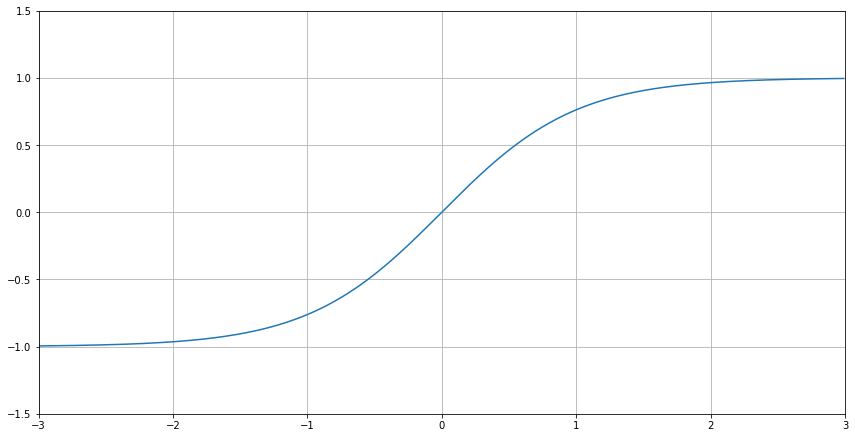

In [4]:
plot(lambda x: math.tanh(x))

### ReLU (*Rectifier Linear Unit*)

$$ g(x) = \max(0, x) $$

#### ReLU – zalety
* Mniej podatna na problem zanikającego gradientu (_vanishing gradient_) niż funkcje sigmoidalne, dzięki czemu SGD jest szybciej zbieżna.
* Prostsze obliczanie gradientu.
* Dzięki zerowaniu ujemnych wartości, wygasza neurony, „rozrzedzając” sieć (_sparsity_), co przyspiesza obliczenia.

#### ReLU – wady
* Dla dużych wartości gradient może „eksplodować”.
* „Wygaszanie” neuronów.

#### ReLU – wykres

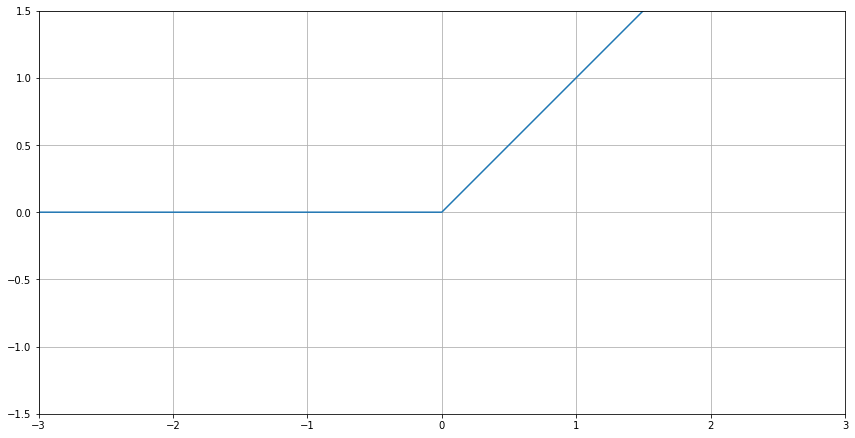

In [5]:
plot(lambda x: max(0, x))

### Softplus

$$ g(x) = \log(1 + e^{x}) $$

* Wygładzona wersja ReLU.

#### Softplus – wykres

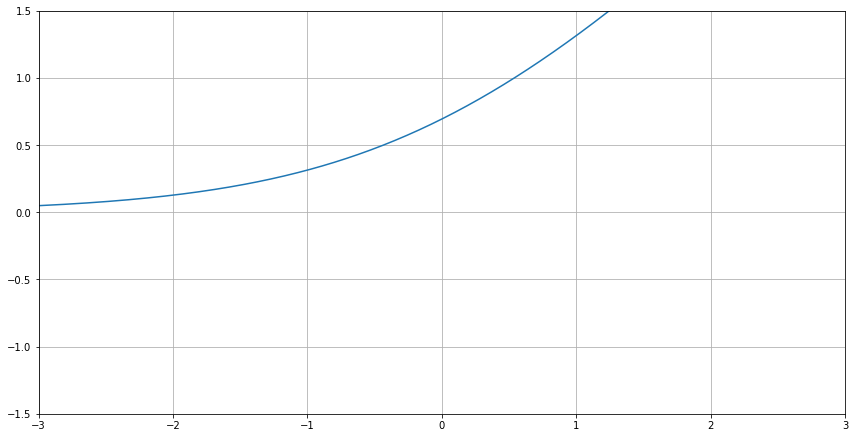

In [6]:
plot(lambda x: math.log(1 + math.exp(x)))

### Problem zanikającego gradientu (*vanishing gradient problem*)

* Sigmoidalne funkcje aktywacji ograniczają wartości na wyjściach neuronów do niewielkich przedziałów ($(-1, 1)$, $(0, 1)$ itp.).
* Jeżeli sieć ma wiele warstw, to podczas propagacji wstecznej mnożymy przez siebie wiele małych wartości → obliczony gradient jest mały.
* Im więcej warstw, tym silniejszy efekt zanikania.

#### Sposoby na zanikający gradient

* Modyfikacja algorytmu optymalizacji (_RProp_, _RMSProp_)
* Użycie innej funckji aktywacji (ReLU, softplus)
* Dodanie warstw _dropout_
* Nowe architektury (LSTM itp.)
* Więcej danych, zwiększenie mocy obliczeniowej

## 11.2. Odmiany metody gradientu prostego

* Batch gradient descent
* Stochastic gradient descent
* Mini-batch gradient descent

### _Batch gradient descent_

* Klasyczna wersja metody gradientu prostego
* Obliczamy gradient funkcji kosztu względem całego zbioru treningowego:
  $$ \theta := \theta - \alpha \cdot \nabla_\theta J(\theta) $$
* Dlatego może działać bardzo powoli
* Nie można dodawać nowych przykładów na bieżąco w trakcie trenowania modelu (_online learning_)

### _Stochastic gradient descent_ (SGD)

* Aktualizacja parametrów dla każdego przykładu:
  $$ \theta := \theta - \alpha \cdot \nabla_\theta \, J \! \left( \theta, x^{(i)}, y^{(i)} \right) $$
* Dużo szybszy niż _batch gradient descent_
* Można dodawać nowe przykłady na bieżąco w trakcie trenowania (_online learning_)

### _Stochastic gradient descent_ (SGD)

* Częsta aktualizacja parametrów z dużą wariancją:

<img src="http://ruder.io/content/images/2016/09/sgd_fluctuation.png" style="margin: auto;" width="50%" />

* Z jednej strony dzięki temu nie utyka w złych minimach lokalnych, ale z drugiej strony może „wyskoczyć” z dobrego minimum

### _Mini-batch gradient descent_

* Kompromis między _batch gradient descent_ i SGD
  $$ \theta := \theta - \alpha \cdot \nabla_\theta \, J \left( \theta, x^{(i : i+n)}, y^{(i : i_n)} \right) $$
* Stabilniejsza zbieżność dzięki redukcji wariancji aktualizacji parametrów
* Szybszy niż klasyczny _batch gradient descent_
* Typowa wielkość batcha: między 50 a 256 przykładów

### Wady klasycznej metody gradientu prostego, czyli dlaczego potrzebujemy optymalizacji

* Trudno dobrać właściwą szybkość uczenia (_learning rate_)
* Jedna ustalona wartość stałej uczenia się dla wszystkich parametrów
* Funkcja kosztu dla sieci neuronowych nie jest wypukła, więc uczenie może utknąć w złym minimum lokalnym lub punkcie siodłowym

## 11.3. Algorytmy optymalizacji metody gradientu

* Momentum
* Nesterov Accelerated Gradient
* Adagrad
* Adadelta
* RMSprop
* Adam
* Nadam
* AMSGrad

### Momentum

* SGD źle radzi sobie w „wąwozach” funkcji kosztu
* Momentum rozwiązuje ten problem przez dodanie współczynnika $\gamma$, który można trakować jako „pęd” spadającej piłki:
  $$ v_t := \gamma \, v_{t-1} + \alpha \, \nabla_\theta J(\theta) $$
  $$ \theta := \theta - v_t $$

### Przyspiesony gradient Nesterova (_Nesterov Accelerated Gradient_, NAG)

* Momentum czasami powoduje niekontrolowane rozpędzanie się piłki, przez co staje się „mniej sterowna”
* Nesterov do piłki posiadającej pęd dodaje „hamulec”, który spowalnia piłkę przed wzniesieniem:
  $$ v_t := \gamma \, v_{t-1} + \alpha \, \nabla_\theta J(\theta - \gamma \, v_{t-1}) $$
  $$ \theta := \theta - v_t $$

### Adagrad

* “<b>Ada</b>ptive <b>grad</b>ient”
* Adagrad dostosowuje współczynnik uczenia (_learning rate_) do parametrów: zmniejsza go dla cech występujących częściej, a zwiększa dla występujących rzadziej
* Świetny do trenowania na rzadkich (_sparse_) zbiorach danych
* Wada: współczynnik uczenia może czasami gwałtownie maleć

### Adadelta i RMSprop
* Warianty algorytmu Adagrad, które radzą sobie z problemem gwałtownych zmian współczynnika uczenia

### Adam

* “<b>Ada</b>ptive <b>m</b>oment estimation”
* Łączy zalety algorytmów RMSprop i Momentum
* Można go porównać do piłki mającej ciężar i opór
* Obecnie jeden z najpopularniejszych algorytmów optymalizacji

### Nadam
* “<b>N</b>esterov-accelerated <b>ada</b>ptive <b>m</b>oment estimation”
* Łączy zalety algorytmów Adam i Nesterov Accelerated Gradient

### AMSGrad
* Wariant algorytmu Adam lepiej dostosowany do zadań takich jak rozpoznawanie obiektów czy tłumaczenie maszynowe

<img src="contours_evaluation_optimizers.gif" style="margin: auto;" width="80%" />

<img src="saddle_point_evaluation_optimizers.gif" style="margin: auto;" width="80%" />